# Evaluation

The most important part of our project includes the evaluation of our ARIMA, XGBoost, and LSTM forecasters. We have saved JSON and pickle files containing the hyperparameters, mean, and standard deviation of the best performing model from each class of forecaster. We will be conducting feature importance, feature ablation, learning curve, and sensitivity analysis on our best model. This notebook will also finish up on a failure analysis which will be included in the final report. Failure analysis may refer to previous plots to illustrate the point of failure.

It's recommended that this notebook is ran with warning ignored, but if not that's ok too. This will work either way, these warnings are mentioned as a point of failure in the final report.

## Imports

In [111]:
import pandas as pd
import numpy as np
import itertools

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from xgboost import XGBRegressor
import shap

from tqdm.notebook import tqdm
import json
import pickle
from typing import List, Dict, Union, Tuple
import warnings

# warnings.resetwarnings()
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
import sys
import os

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.join(notebook_dir, '../..')
sys.path.append(scripts_dir)

from scripts.utils import *
from scripts.optimization import BayesianOptimization, BayesianOptimizationConfig

## Reporting the Model Families and our Best Model

Each of these files have their own notebook behind them. Please refer to them if you need clarification on how this was completed. MAE was used in order to correctly capture the magnitude of errors without becoming out of hand.

In [3]:
with open("ARIMA_params.json", 'r') as f:
    arima = json.load(f)
arima

{'params': [3, 1, 4], 'mean': 8982.000373589684, 'std': 1079.1711995197873}

In [4]:
with open('xgboostforecaster.pkl', 'rb') as picklefile:
    bayesian_opt = pickle.load(picklefile)
bayesian_opt.best_params()

{'params': {'n_estimators': 1027,
  'max_depth': 9,
  'learning_rate': 0.58,
  'subsample': 0.966,
  'colsample_bytree': 0.724,
  'gamma': 0.157,
  'reg_alpha': 0.269,
  'reg_lambda': 0.022},
 'lag': 6,
 'differentiation': None,
 'mean': 14329.429607928241,
 'std': 6344.947220145858}

In [5]:
with open("lstm_params.json", 'r') as f:
    lstm = json.load(f)
idx = np.argmin(lstm['objectives'])
lstm['hyperparameters'][idx], lstm['objectives'][idx]

([8, 1, 0.005], 91951.585546875)

## Deep Dive on the Best Performing Model (ARIMA)

In [161]:
data = pd.read_csv("../../../data/dataset.csv", parse_dates=['date'])
thresh = int(0.9 * len(data))
data = data.dropna(axis=1, thresh=thresh).bfill().ffill().drop('demand', axis=1)
split = int(len(data) * 0.85)
train, test = data.iloc[:split, :], data.iloc[split:, :]

order = (3, 1, 4)

endog_train, exog_train = train['consumption'], train.drop(['date', 'consumption'], axis=1)
endog_test, exog_test = test['consumption'], test.drop(['date', 'consumption'], axis=1)
model = ARIMA(endog_train, exog_train.astype(float), order=order).fit()

In [215]:
# data.describe().T

In [216]:
# data.info()

## Errors on the Test Dataset

We can analyze how the model does on the test set to see how it fails.

In [206]:
predictions = model.forecast(steps=len(endog_test), exog=exog_test)
errors = (predictions - endog_test)
mae = mean_absolute_error(predictions, endog_test)
dates = test.date

error_df = pd.concat([dates, errors], axis=1).reset_index(drop=True)
error_df.columns = ['date', 'errors']
error_df['color'] = np.where(error_df['errors']<0, 'red', 'blue')

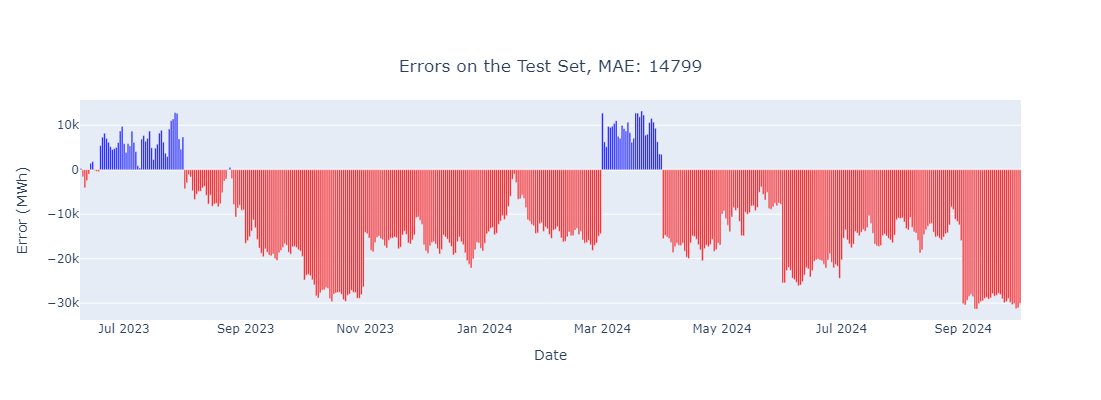

In [212]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = error_df.date,
        y = error_df.errors,
        marker_color = error_df.color
    )
)
fig.update_layout(
    title={"text": f"Errors on the Test Set, MAE: {mae:.0f}", "xanchor": 'center', 'x': 0.5, 'y':0.85},
    xaxis_title="Date",
    yaxis_title="Error (MWh)",
    height=400,
    width=800
)
fig.show()
fig.write_image("errors.png")

Taking the above plot further we can take it a step further to look at how the train and test data differs below. In the end we see that they are essentially different distributions.

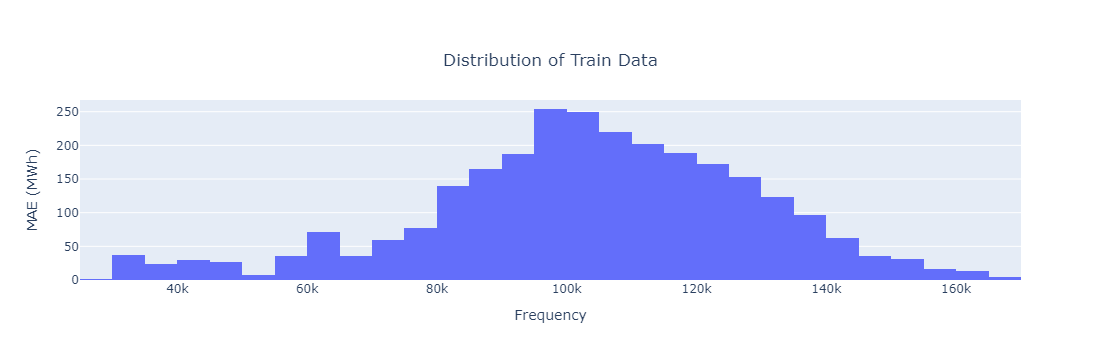

In [225]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x = endog_train
    )
)
fig.update_layout(
    title={"text": "Distribution of Train Data", "xanchor": 'center', 'x': 0.5, 'y':0.85},
    xaxis_title="Frequency",
    yaxis_title="MAE (MWh)"
)
fig.show()
fig.write_image("traindist.png")

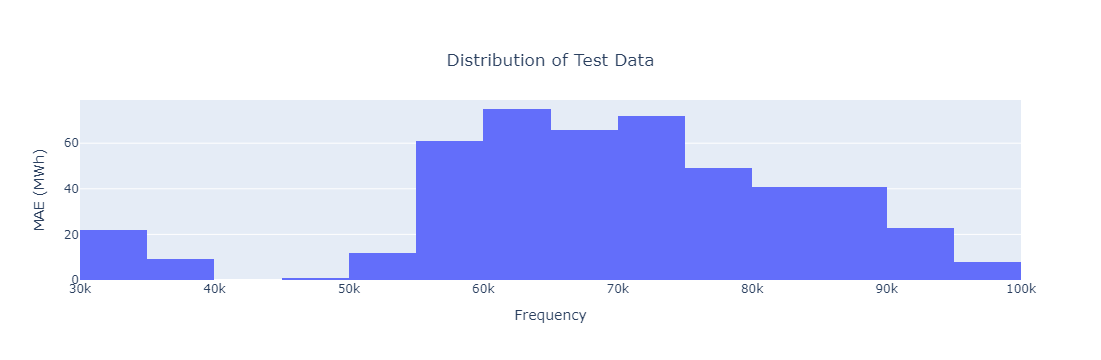

In [224]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x = endog_test
    )
)
fig.update_layout(
    title={"text": "Distribution of Test Data", "xanchor": 'center', 'x': 0.5, 'y':0.85},
    xaxis_title="Frequency",
    yaxis_title="MAE (MWh)"
)
fig.show()
fig.write_image("testdist.png")

In [220]:
endog_train.mean(), endog_test.mean()

(103362.3265832106, 69138.94375)

### Feature Importance

The SHAP library does a lot of the heavy lifting for us by having a KernelExplainer that essentially jitters input to help see what is the most important. This was done by training on the entire train set from above using the best ARIMA order.

Running the feature importance cell will take about 12 minutes.

In [9]:
def forecasting(X):
    return model.forecast(steps=len(X), exog=X)

explainer = shap.KernelExplainer(forecasting, exog_train.iloc[-50:])
shap_values = explainer.shap_values(exog_test)
shape_values

  0%|          | 0/480 [00:00<?, ?it/s]

shap       INFO  num_full_subsets = 1
shap       INFO  remaining_weight_vector = array([0.20701126, 0.14490788, 0.11440096, 0.09660526, 0.08523993,
       0.07762922, 0.07245394, 0.06900375, 0.06688056, 0.06586722])
shap       INFO  num_paired_subset_sizes = 11
shap       INFO  weight_left = 0.7167414131850209
shap       INFO  np.sum(w_aug) = 23.0
shap       INFO  np.sum(self.kernelWeights) = 1.0000000000000002
shap       INFO  phi = array([ 6.38269137e+03,  2.43930692e+03, -5.99391732e+02, -1.26148319e+03,
        3.74307239e+02,  4.05691984e+02, -2.40122293e+02,  1.60669179e+03,
        3.27430463e+01,  4.06065684e+00,  2.89251323e+02, -1.73274481e+01,
       -8.19648705e+02,  1.70198835e+03,  2.44029557e+01, -1.18331105e+01,
        4.74120572e+02, -5.29657947e+02,  4.42869687e+01, -6.84398812e+01,
        3.55484691e+01, -3.79848405e+01,  2.31478373e+01])
shap       INFO  num_full_subsets = 1
shap       INFO  remaining_weight_vector = array([0.20701126, 0.14490788, 0.11440096, 0.09

NameError: name 'shape_values' is not defined

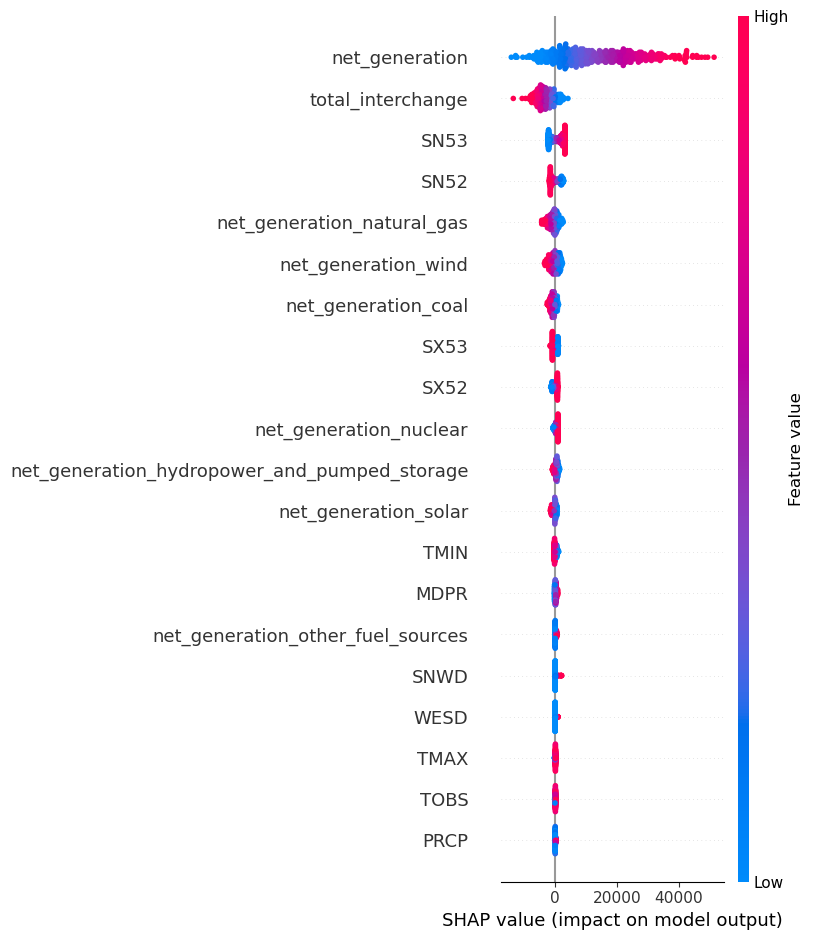

In [36]:
shap.summary_plot(shap_values, exog_test, plot_type="dot", show=False)
plt.savefig("shap_summary.png")
plt.show()

In [47]:
# model.summary()

### Ablation Analysis

We can easily group our features into 3 groups for ablation: electrical grid data, weather data, and exogenous variables which are both of them. We need the consumption feature regardless, so there's no dropping this in any circumstance. These are exogenous and let's see if we actually need them. 


This takes less than 30 seconds to run.

In [24]:
ablated_features = [
    ['net_generation', 'total_interchange', 'net_generation_coal',
       'net_generation_natural_gas', 'net_generation_nuclear',
       'net_generation_hydropower_and_pumped_storage', 'net_generation_solar',
       'net_generation_wind'],
    ['DAPR', 'MDPR', 'PRCP', 'SN52', 'SN53', 'SNOW', 'SNWD', 'SX52', 'SX53', 'TMAX',
       'TMIN', 'TOBS', 'WESD', 'WSFG', 'WT01', 'WT03', 'WT11'],
    ['net_generation', 'total_interchange', 'net_generation_coal',
       'net_generation_natural_gas', 'net_generation_nuclear',
       'net_generation_hydropower_and_pumped_storage', 'net_generation_solar',
       'net_generation_wind', 'net_generation_other_fuel_sources', 'DAPR',
       'MDPR', 'PRCP', 'SN52', 'SN53', 'SNOW', 'SNWD', 'SX52', 'SX53', 'TMAX',
       'TMIN', 'TOBS', 'WESD', 'WSFG', 'WT01', 'WT03', 'WT11']
]
btss = BlockingTimeSeriesSplit(n_splits=5, val_size=0.2)
objectives = []
stds = []
for ablate in tqdm(ablated_features):
    maes = []
    for i, (x, y) in enumerate(btss.split(train)):
        endog_train = train.loc[x, 'consumption'].reset_index(drop=True).astype(float)
        endog_val = train.loc[y, 'consumption'].reset_index(drop=True).astype(float)
        if len(ablate) != len(train.columns) - 2:
            exog_train = train.loc[x].drop(['date', 'consumption'] + ablate, axis=1).reset_index(drop=True)
            exog_val = train.loc[y].drop(['date', 'consumption'] + ablate, axis=1).reset_index(drop=True)
        else:
            exog_train = None
            exog_val = None
        model = ARIMA(endog_train, exog_train, order=order).fit()
        predictions = model.forecast(steps=len(endog_val), exog=exog_val)
        maes.append(mean_absolute_error(predictions, endog_val))
    objectives.append(np.mean(maes))
    stds.append(np.std(maes))

  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
for ablate, obj, std in zip(['Drop Grid data', 'Drop Weather data', 'All Exogs'], objectives, stds):
    print(f"{ablate}\t Mean: {obj}\t Standard Deviation: {std}")

Drop Grid data	 Mean: 16338.987550249914	 Standard Deviation: 5029.5118112639375
Drop Weather data	 Mean: 10476.834331463933	 Standard Deviation: 916.0526267047969
All Exogs	 Mean: 22836.740992546016	 Standard Deviation: 12595.483925184828


### Sensitivity Analysis

Hyperparameters for the ARIMA model lie in the P, D, Q scheme of choices. We will explore how each varies and plot it. There will be a 3d plot at the end that is recommended to explore. This functions off of the quantile ranges where it's also recommended to configure different values. Please note the errors and scale of the 3d plot when configuring different runs. Run the `alt_orders` cell once to complete this.

Getting the orders of each takes around 1 hour to run.

In [115]:
order

(3, 1, 4)

In [116]:
def generate_alt_orders(orders, max_diff: int):
    P, D, Q = orders
    Ps = range(max(P-max_diff, 0), P+max_diff)
    Ds = range(max(D-max_diff, 0), D+max_diff)
    Qs = range(max(Q-max_diff, 0), Q+max_diff)
    return list(itertools.product(Ps, Qs, Ds))

In [117]:
alt_orders = generate_alt_orders(order, 5)
btss = BlockingTimeSeriesSplit(n_splits=5, val_size=0.2)
searched_orders = {}
for ods in tqdm(alt_orders):
    maes = []
    try:
        for i, (x, y) in enumerate(btss.split(train)):
            endog_train = train.loc[x, 'consumption'].reset_index(drop=True).astype(float)
            endog_val = train.loc[y, 'consumption'].reset_index(drop=True).astype(float)
            exog_train = train.loc[x].drop(['date', 'consumption'], axis=1).reset_index(drop=True)
            exog_val = train.loc[y].drop(['date', 'consumption'], axis=1).reset_index(drop=True)
            model = ARIMA(endog_train, exog_train, order=ods).fit()
            predictions = model.forecast(steps=len(endog_val), exog=exog_val)
            maes.append(mean_absolute_error(predictions, endog_val))
        searched_orders[ods] = {'mean': np.mean(maes), 'std': np.std(maes)}
    except Exception as e:
        print(ods, e)

  0%|          | 0/432 [00:00<?, ?it/s]

(0, 0, 0) A constant trend was included in the model specification, but the `exog` data already contains a column of constants.
(0, 0, 1) A constant trend was included in the model specification, but the `exog` data already contains a column of constants.
(0, 0, 2) A constant trend was included in the model specification, but the `exog` data already contains a column of constants.
(0, 0, 3) A constant trend was included in the model specification, but the `exog` data already contains a column of constants.
(0, 0, 4) A constant trend was included in the model specification, but the `exog` data already contains a column of constants.
(0, 0, 5) A constant trend was included in the model specification, but the `exog` data already contains a column of constants.
(1, 0, 0) A constant trend was included in the model specification, but the `exog` data already contains a column of constants.
(1, 0, 1) A constant trend was included in the model specification, but the `exog` data already contains

In [124]:
P = [P for P, Q, D in searched_orders.keys()]
Q = [Q for P, Q, D in searched_orders.keys()]
D = [D for P, Q, D in searched_orders.keys()]
means = [val['mean'] for val in searched_orders.values()]
stds = [val['std'] for val in searched_orders.values()]
sens_df = pd.DataFrame(zip(P, Q, D, means, stds), columns=['P', 'Q', 'D', 'means', 'stds'])
sens_df

,P,Q,D,means,stds
0,0,1,0,9.153151e+03,1.018709e+03
1,0,1,1,9.208061e+03,1.013690e+03
2,0,1,2,9.186833e+03,9.937148e+02
3,0,1,3,9.118336e+03,9.990414e+02
4,0,1,4,9.048036e+03,1.043332e+03
...,...,...,...,...,...
377,7,8,1,1.196006e+19,2.392012e+19
378,7,8,2,1.315361e+10,1.089287e+10
379,7,8,3,1.815019e+10,1.615459e+10
380,7,8,4,3.339613e+10,1.326565e+10


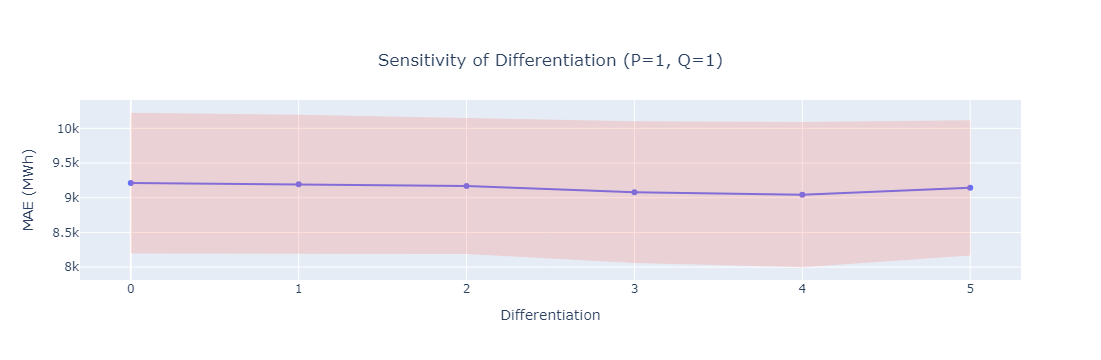

In [147]:
x = sens_df[(sens_df.P==1)&(sens_df.Q==1)].D
y = sens_df[(sens_df.P==1)&(sens_df.Q==1)].means
stds = sens_df[(sens_df.P==1)&(sens_df.Q==1)].stds
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        showlegend=False,
        fillcolor='rgba(255,0,0,0)'
    )
)
fig.add_trace(
    go.Scatter(
        x = pd.concat([x, x[::-1]]),
        y = pd.concat([y + stds, (y - stds)[::-1]]),
        fill='toself',
        fillcolor='rgba(255,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    )
)
fig.update_layout(
    title={"text": "Sensitivity of Differentiation (P=1, Q=1)", "xanchor": 'center', 'x': 0.5, 'y':0.85},
    xaxis_title="Differentiation",
    yaxis_title="MAE (MWh)"
)
fig.show()
fig.write_image("sensdiff.png")

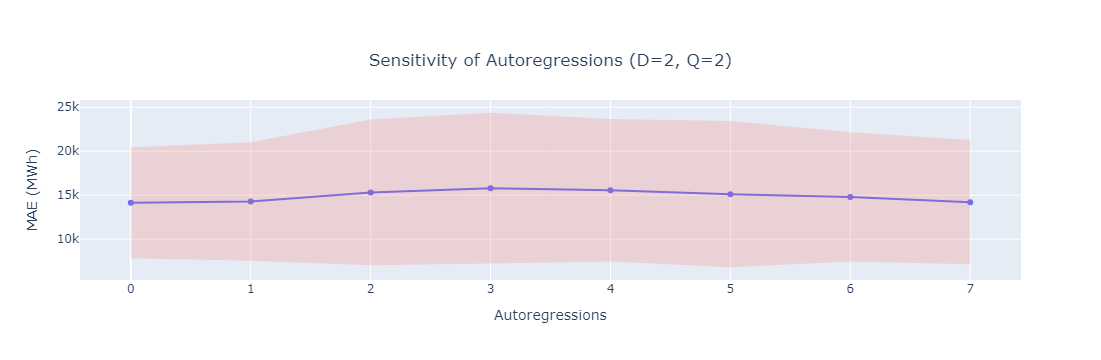

In [148]:
x = sens_df[(sens_df.D==2)&(sens_df.Q==2)].P
y = sens_df[(sens_df.D==2)&(sens_df.Q==2)].means
stds = sens_df[(sens_df.D==2)&(sens_df.Q==2)].stds
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        showlegend=False
    )
)
fig.add_trace(
    go.Scatter(
        x = pd.concat([x, x[::-1]]),
        y = pd.concat([y + stds, (y - stds)[::-1]]),
        fill='toself',
        fillcolor='rgba(255,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    )
)
fig.update_layout(
    title={"text": "Sensitivity of Autoregressions (D=2, Q=2)", "xanchor": 'center', 'x': 0.5, 'y':0.85},
    xaxis_title="Autoregressions",
    yaxis_title="MAE (MWh)"
)
fig.show()
fig.write_image("sensar.png")

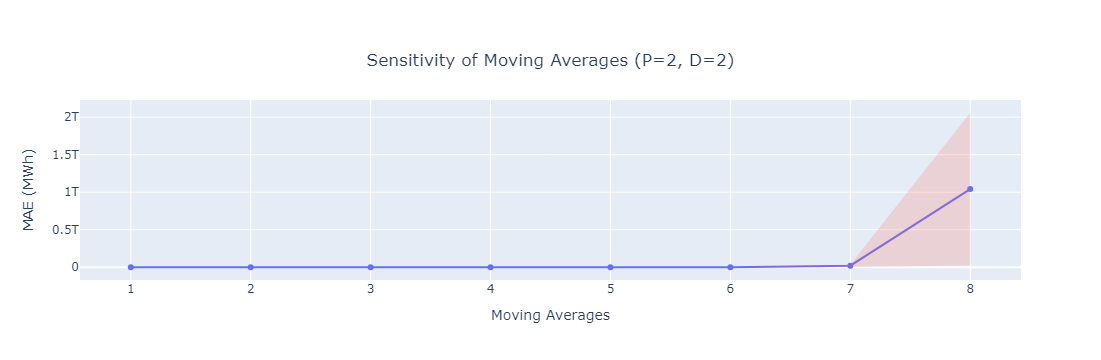

In [149]:
x = sens_df[(sens_df.D==2)&(sens_df.P==0)].Q
y = sens_df[(sens_df.D==2)&(sens_df.P==0)].means
stds = sens_df[(sens_df.D==2)&(sens_df.P==0)].stds
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        showlegend=False
    )
)
fig.add_trace(
    go.Scatter(
        x = pd.concat([x, x[::-1]]),
        y = pd.concat([y + stds, (y - stds)[::-1]]),
        fill='toself',
        fillcolor='rgba(255,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    )
)
fig.update_layout(
    title={"text": "Sensitivity of Moving Averages (P=2, D=2)", "xanchor": 'center', 'x': 0.5, 'y':0.85},
    xaxis_title="Moving Averages",
    yaxis_title="MAE (MWh)"
)
fig.show()
fig.write_image("sensma.png")

In [138]:
q = sens_df.means.quantile(0.3)
bigplot = sens_df[(sens_df.means <= q)]

In [156]:
fig = go.Figure()
fig.add_trace(
    go.Scatter3d(
        x=bigplot.P,
        y=bigplot.D,
        z=bigplot.Q,
        mode='markers',
        marker=dict(
            size=6,
            color=bigplot.means,
            colorbar={'title': 'MAE (MWh)'},
            showscale=True
        )
    )
)
fig.update_layout(
    title={"text": "Sensitivity for ARIMA Hyperparameters", "xanchor": 'center', 'x': 0.5, 'y':0.85},
    scene=dict(xaxis_title="Autoregressions",
    yaxis_title="Differentiations",
    zaxis_title="Moving Averages"),
    height=800,
    width=1000
)
fig.show()
fig.write_image("3dplot.png")

### Training Data Size vs. MAE

Learning curves are much simpler compared to the above. This is straightforward. We start with a small subset of data from the start date and we have a small subset of data. We slowly increase it and see if the error decreases. Feel free to change the `start` variable to any float value, larger or smaller, to see how the model reacts to data. If you're running this without warnings ignored also note how often warnings come up with fitting the ARIMA model.

Having start on 0.05 (in the final report) this cell took about 3 minutes to run.

In [12]:
plot_xs = []
frac_maes = []
start = 0.05
for frac in tqdm(np.arange(start, 0.86, start)):
    split = int(len(data) * frac)
    partial_data = data.iloc[:split, :]
    for i, (x, y) in enumerate(btss.split(partial_data)):
        endog_train = partial_data.loc[x, 'consumption'].reset_index(drop=True).astype(float)
        endog_val = partial_data.loc[y, 'consumption'].reset_index(drop=True).astype(float)
        exog_train = partial_data.loc[x].drop(['date', 'consumption'], axis=1).reset_index(drop=True)
        exog_val = partial_data.loc[y].drop(['date', 'consumption'], axis=1).reset_index(drop=True)
        model = ARIMA(endog_train, exog_train, order=order).fit()
        predictions = model.forecast(steps=len(endog_val), exog=exog_val)
        maes.append(mean_absolute_error(predictions, endog_val))
    plot_xs.append(split)
    frac_maes.append((np.mean(maes), np.std(maes)))

  0%|          | 0/17 [00:00<?, ?it/s]

/home/luismg0203/miniconda3/envs/forecasting/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/luismg0203/miniconda3/envs/forecasting/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/luismg0203/miniconda3/envs/forecasting/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/luismg0203/miniconda3/envs/forecasting/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as startin

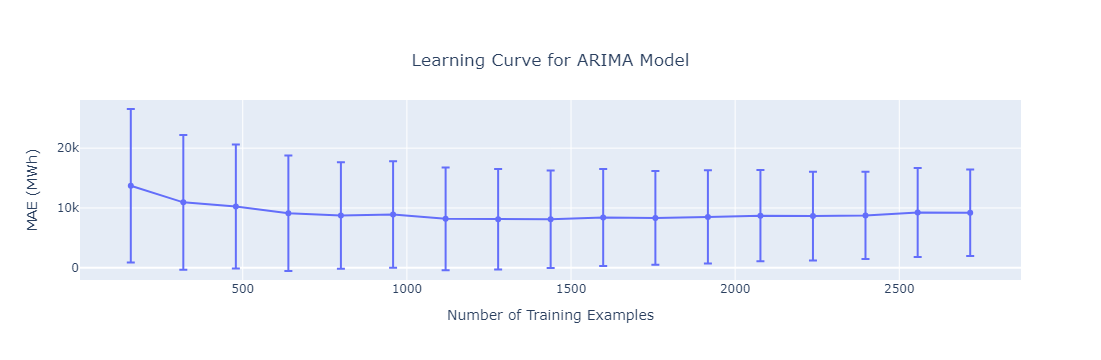

In [22]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=plot_xs,
        y=[mae for mae, _ in frac_maes],
        error_y=dict(type='data', array=[std for _, std in frac_maes])
    )
)
fig.update_layout(
    title={"text": "Learning Curve for ARIMA Model", "xanchor": 'center', 'x': 0.5, 'y':0.85},
    xaxis_title="Number of Training Examples",
    yaxis_title="MAE (MWh)"
)
fig.show()
fig.write_image("learning_curve.png")